In [4]:
#```{r results='hide', message=FALSE, warning=FALSE}
# install all Packages required
# install.packages('ggplot2')
# Load Libraries to be used
library(ggplot2)
library(knitr)
library(dplyr)
library(tidyverse)
library(summarytools)
library(visdat)
library(igraph)
#library(treemap)
#library(dplyr)
library(devtools)
library("readxl")
library(repr)
library(forecast)
library(lubridate)
library(forecast)
#install.packages("readxl")
#install.packages("lubridate")
#install.packages("forecast")
# my_data <- read_excel(file.choose())
#```# Do not show warnings


Attaching package: 'lubridate'


The following objects are masked from 'package:igraph':

    %--%, union


The following objects are masked from 'package:base':

    date, intersect, setdiff, union




In [2]:
yearly_df <- read_excel("Data/gap.xlsx", sheet="Yearly")

head(yearly_df)

Year,Sales,GDP
<dbl>,<dbl>,<dbl>
1984,NA,6577.125
1985,647.333,6849.250
1986,848.009,7086.550
1987,1062.021,7313.275
1988,1252.097,7613.900
1989,1586.596,7885.925


In [3]:
quart_df <- read_excel("Data/gap.xlsx", sheet="Quarterly")

head(quart_df)

Quarter,Sales
<chr>,<dbl>
1985 - I,105.715
1985 - II,120.136
1985 - III,181.669
1985 - IV,239.813
1986 - I,159.980
1986 - II,164.760


In [7]:
# import data
d <- read_xlsx("Data/gap.xlsx", sheet = "Quarterly")

In [8]:

# time
d$time <- c(1:112)
d$quarter <- rep(1:4,28)

In [9]:
head(d)

Quarter,Sales,time,quarter
<chr>,<dbl>,<int>,<int>
1985 - I,105.715,1,1
1985 - II,120.136,2,2
1985 - III,181.669,3,3
1985 - IV,239.813,4,4
1986 - I,159.980,5,1
1986 - II,164.760,6,2


In [10]:
# Quadratic model ---------------------------------------------------------

# trend
trend <- lm(Sales ~ time+I(time^2)+I(time^3)+I(time^4)+I(time^5), data = d)
d$trend <-  predict(trend)

In [11]:
summary(trend)


Call:
lm(formula = Sales ~ time + I(time^2) + I(time^3) + I(time^4) + 
    I(time^5), data = d)

Residuals:
    Min      1Q  Median      3Q     Max 
-709.12 -255.61  -85.24  124.89 1359.97 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.226e+02  2.381e+02  -1.355 0.178382    
time         1.554e+02  4.192e+01   3.708 0.000334 ***
I(time^2)   -1.082e+01  2.274e+00  -4.758 6.22e-06 ***
I(time^3)    3.061e-01  5.076e-02   6.031 2.41e-08 ***
I(time^4)   -3.286e-03  4.943e-04  -6.648 1.33e-09 ***
I(time^5)    1.190e-05  1.741e-06   6.837 5.35e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 387.7 on 106 degrees of freedom
Multiple R-squared:  0.942,	Adjusted R-squared:  0.9393 
F-statistic: 344.5 on 5 and 106 DF,  p-value: < 2.2e-16


In [25]:
str(trend)

List of 12
 $ coefficients : Named num [1:6] -3.23e+02 1.55e+02 -1.08e+01 3.06e-01 -3.29e-03 ...
  ..- attr(*, "names")= chr [1:6] "(Intercept)" "time" "I(time^2)" "I(time^3)" ...
 $ residuals    : Named num [1:112] 283.4 172.7 127.3 95 -60.5 ...
  ..- attr(*, "names")= chr [1:112] "1" "2" "3" "4" ...
 $ effects      : Named num [1:112] -23727 15157 1933 -4244 -607 ...
  ..- attr(*, "names")= chr [1:112] "(Intercept)" "time" "I(time^2)" "I(time^3)" ...
 $ rank         : int 6
 $ fitted.values: Named num [1:112] -177.7 -52.6 54.4 144.9 220.4 ...
  ..- attr(*, "names")= chr [1:112] "1" "2" "3" "4" ...
 $ assign       : int [1:6] 0 1 2 3 4 5
 $ qr           :List of 5
  ..$ qr   : num [1:112, 1:6] -10.583 0.0945 0.0945 0.0945 0.0945 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:112] "1" "2" "3" "4" ...
  .. .. ..$ : chr [1:6] "(Intercept)" "time" "I(time^2)" "I(time^3)" ...
  .. ..- attr(*, "assign")= int [1:6] 0 1 2 3 4 5
  ..$ qraux: num [1:6] 1.09 1.15 1.14 1.1 1.03 .

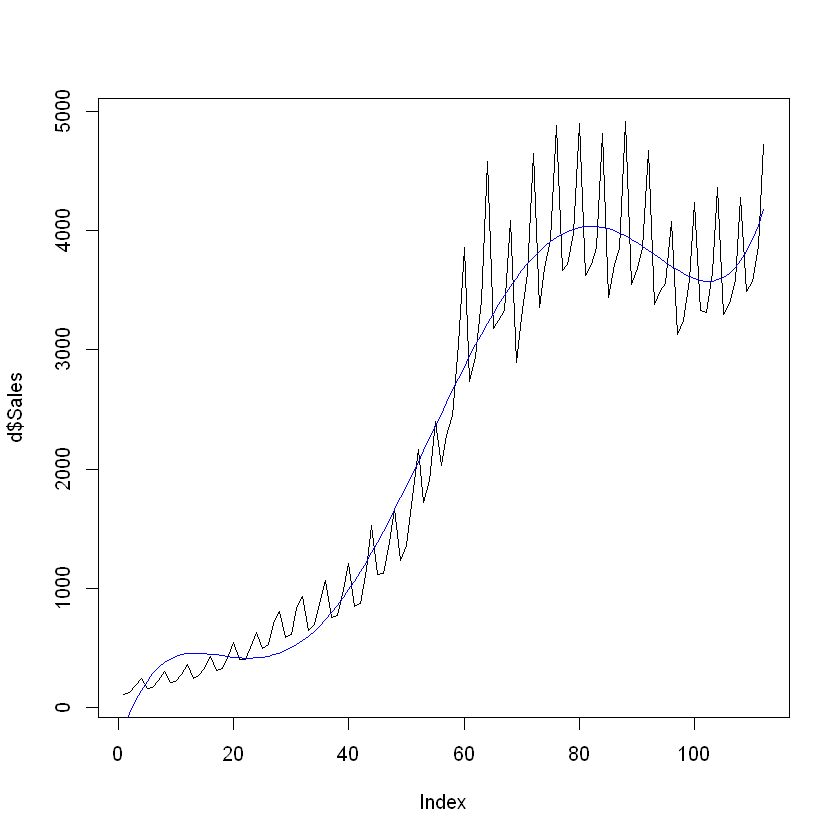

In [12]:
# plot
plot(d$Sales, type="l")
lines(d$trend, type="l", col="blue")

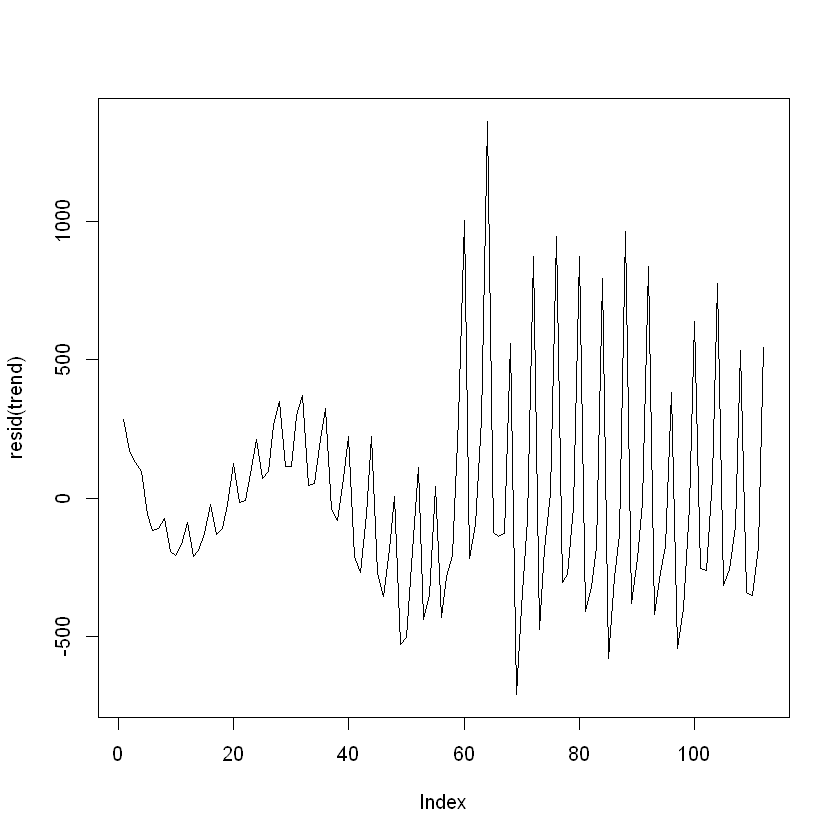

In [13]:
# residual
plot(resid(trend), type="l")

In [14]:
# seasonal multiplicative 
d$multi <- d$Sales / d$trend
d <- d %>% group_by(quarter) %>% mutate(seasonal = mean(multi))

In [15]:
# prediction multiplicative
d$predicted <- d$trend * d$seasonal 

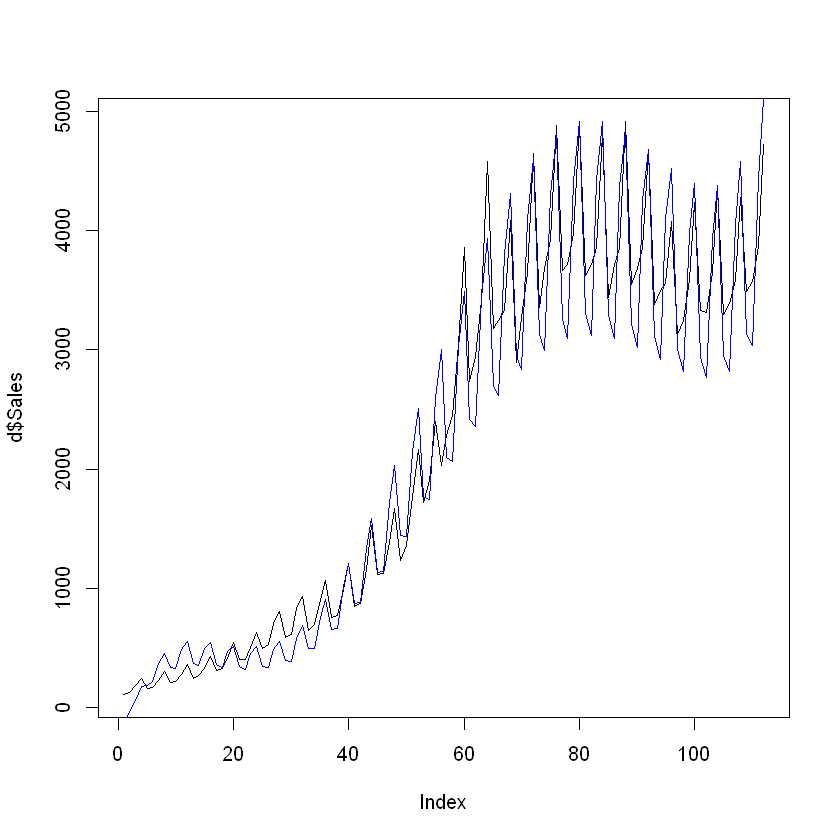

In [16]:
# plot predictions
plot(d$Sales, type="l")
lines(d$predicted, type="l", col="blue")

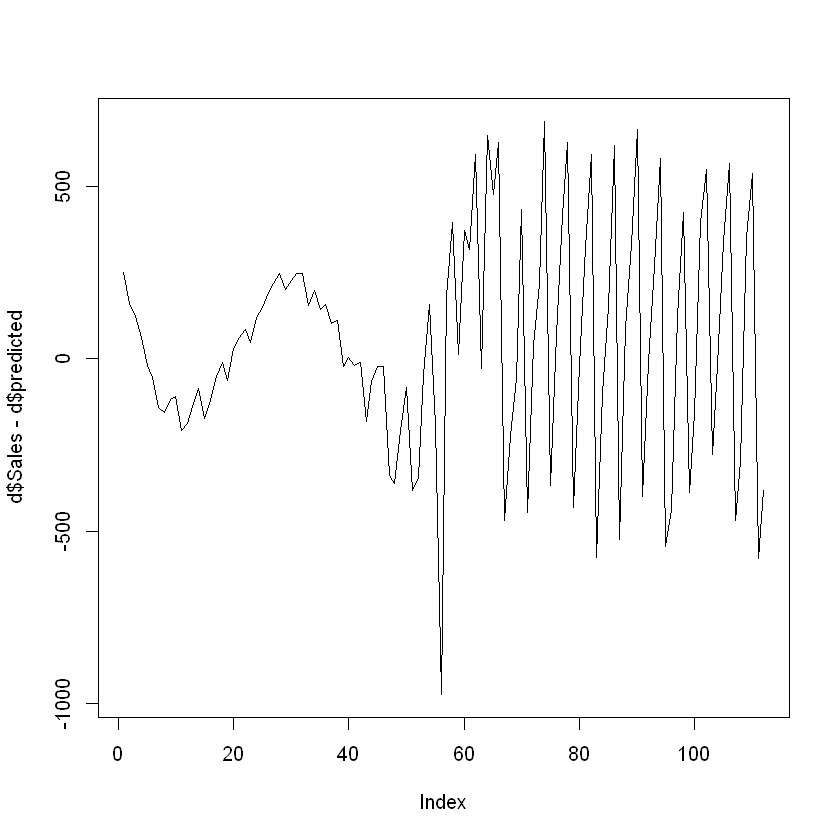

In [17]:
# residual
plot(d$Sales - d$predicted, type="l")


In [18]:
# Holt-Winters ------------------------------------------------------------

library(forecast)

# time series data
d.ts <- ts(d$Sales, frequency=4)


In [19]:
head(d.ts)

,Qtr1,Qtr2,Qtr3,Qtr4
1,105.715,120.136,181.669,239.813
2,159.980,164.760,,


In [21]:
# HW model
hw <- ets(d.ts, model="MAM", alpha=0.2, beta=0.2, gamma=0.2)
head(hw$fitted)

,Qtr1,Qtr2,Qtr3,Qtr4
1,108.5173,122.5963,170.7011,234.2317
2,170.6721,177.9985,,


In [22]:
cor(hw$fitted,d$Sales)

[1] 0.9921296

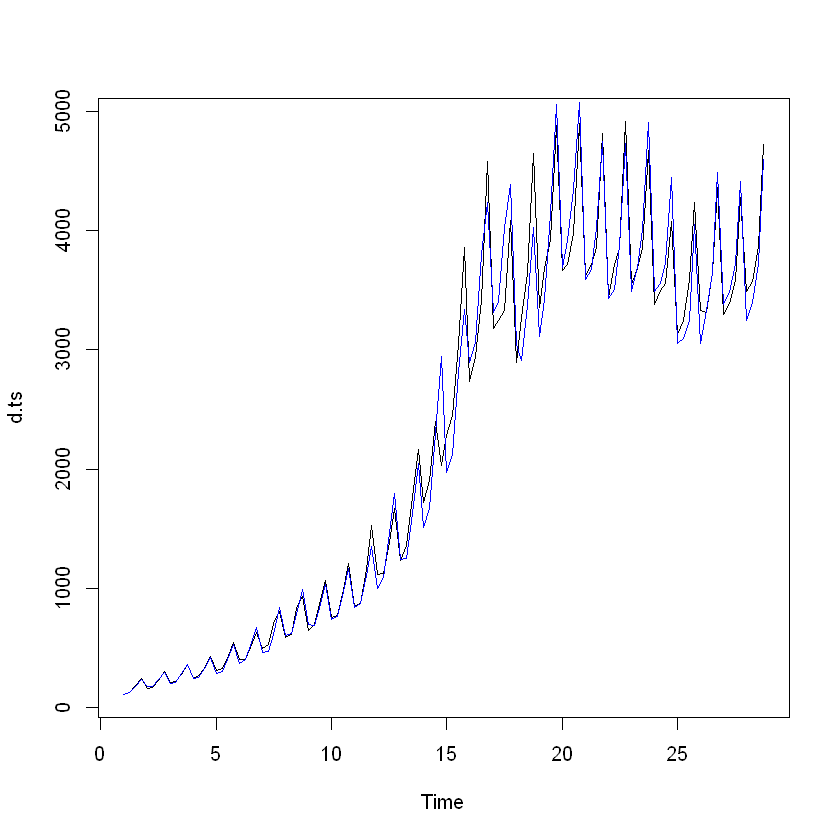

In [23]:
# plot 
plot(d.ts, type="l")
lines(hw$fitted, type="l",col="blue")

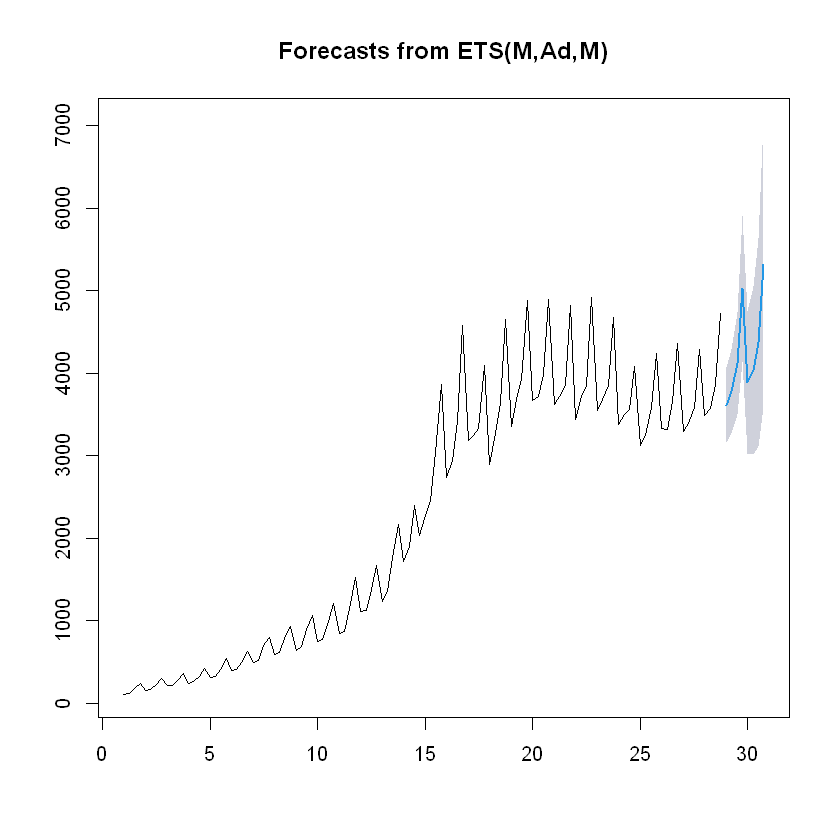

In [24]:
# forecast
forecast <- forecast(hw, h=8, level=c(90))
plot(forecast)